In [2]:
# Autoreload 
%load_ext autoreload
%autoreload 2

device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch 
import matplotlib.pyplot as plt

# Elemental Mapping

An element map is an image showing the spatial distribution of elements in a sample. Because it is acquired from a polished section, it is a 2D section through the unknown sample. Element maps are extremely useful for displaying element distributions in textural context, particularly for showing compositional zonation.

### Fully Connected Model

In [4]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

In [5]:
training_images = ['gogo', 'dionisios', 'fanourios', 'odigitria', 'minos']
test_images = ['saintjohn']

In [6]:
band_range = (80, 2128)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=training_images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(80, 2128), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [7]:
# Define the Fully Connected Model
from Elemental_Mapping.models.FullyConnectedModel import FullyConnectedModel

in_features = band_range[1]-band_range[0]
out_features = len(dataset.target_elems)
fcn = FullyConnectedModel(in_features=in_features, out_features=out_features, hidden_dims=[1024, 512, 256, 64])
fcn.to(device)

FullyConnectedModel(
  (layers): ModuleList(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [8]:
# Define Criterion and optimizer
from Elemental_Mapping.loss_functions.AdaptiveL1Loss import AdaptiveL1Loss
import torch.optim as optim
    
criterion = AdaptiveL1Loss()
fcn_optimizer = optim.Adam(fcn.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
num_epochs = 1000

for epoch in range(num_epochs):
    train_loss = fcn.train(train_loader, fcn_optimizer, criterion, epochs=1, device=device)
    val_loss, pred = fcn.eval(val_loader, criterion, device=device)
    print(f'Epoch: {epoch}, Train Loss: {round(train_loss, 4)}, Val Loss: {round(val_loss, 4)}')
    # Save model 
    torch.save(fcn.state_dict(), f'./results/Elemental_Mapping/fcn_{fcn.hidden_dims}_best.pt')

In [10]:
# Load state dict
fcn.load_state_dict(torch.load(f'./results/Elemental_Mapping/fcn_{fcn.hidden_dims}_best.pt'))

<All keys matched successfully>

In [11]:
testset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=test_images,
    sample_step = 1,
    device='cuda',
    band_range=(80, 2128),
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [12]:
from utils import open_target_image
real = open_target_image(f'/home/igeor/MSC-THESIS/data/h5/elem_maps/{test_images[0]}.dat')
h, w, _ = real.shape
real = torch.tensor(real).to(device)

In [13]:
# Estimate the elemental map
score, pred = fcn.eval(test_loader, criterion, device=device)
pred = pred.reshape(h, w, len(testset.target_elems))
print(f'Loss: {round(score, 4)}')

Loss: 43.1865


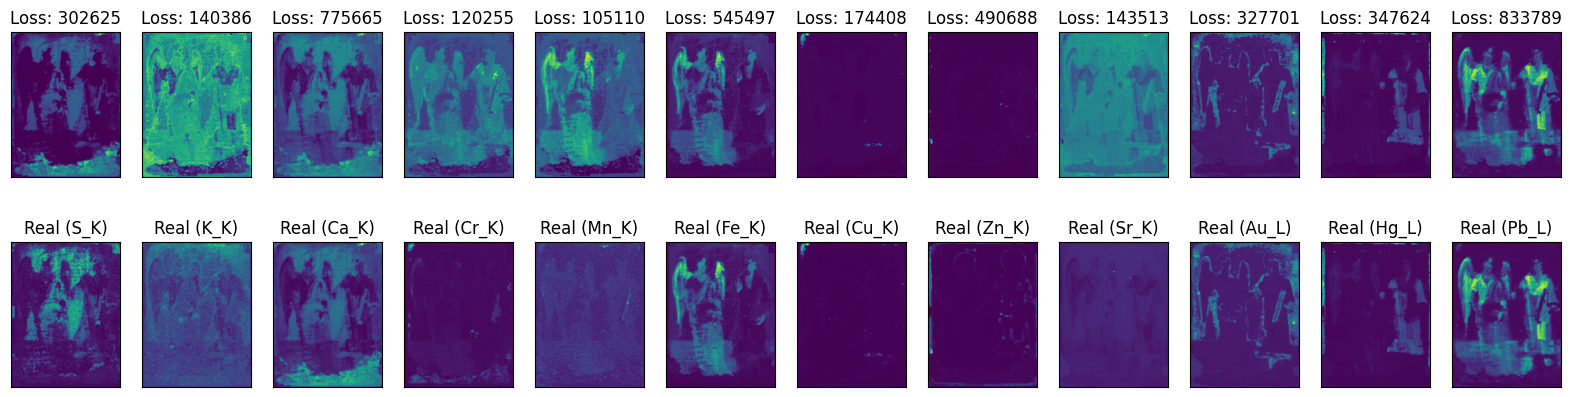

In [23]:
# plot all 12 real and pred bands
fig, axs = plt.subplots(2, 12, figsize=(20, 5))
for i in range(12):
    i_pred = pred[:,:,i].cpu().detach()
    i_real = real[:,:,i].cpu().detach()
    
    loss = criterion(i_pred, i_real)
    
    axs[0, i].set_title(f'Loss: {round(loss.item())}')
    axs[1, i].set_title(f'Real ({testset.target_elems[i]})')

    axs[0, i].imshow(i_pred.numpy())
    axs[1, i].imshow(i_real.numpy())

    # set the ticks off
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

##### Explainability

In [102]:
x = torch.cat([train_dataset[i][0] for i in range(len(train_dataset))], dim=0)
x = torch.sum(x, dim=0)
# Compute the dot product of the weight matrix with the input vector
w = torch.abs(fcn.layers[0].weight)

Text(0.5, 1.0, 'Weights values for each input feature')

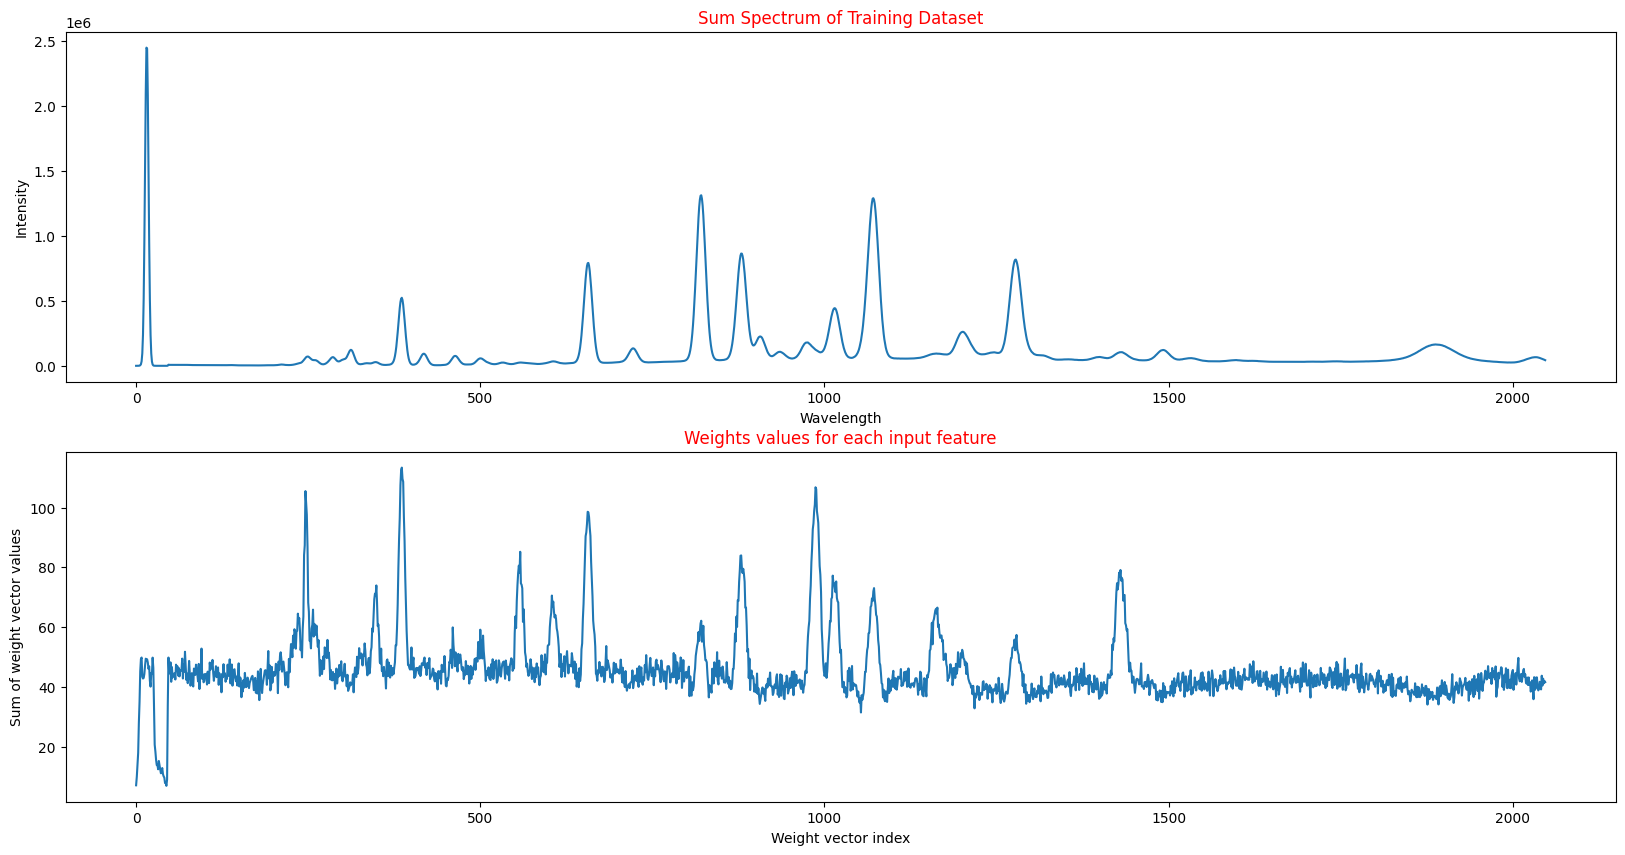

In [112]:
# Compute the maximum value of the weight tensor for each input feature
max_values = w.sum(dim=0)#[0]

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(x.cpu().detach().numpy())
axs[1].plot(max_values.cpu().detach().numpy())

axs[0].set_xlabel('Wavelength')
axs[0].set_ylabel('Intensity')
axs[0].set_title('Sum Spectrum of Training Dataset', color='red')

axs[1].set_xlabel('Weight vector index')
axs[1].set_ylabel('Sum of weight vector values')
axs[1].set_title('Weights values for each input feature', color='red')

### 1D Conovolutional Model